In [13]:
import uproot
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from functions import root_to_np



index       = [ "B_sig_K_dr","B_sig_K_dz","B_sig_CleoConeCS_3_ROE", "thrustAxisCosTheta","aplanarity","sphericity",
                "harmonicMomentThrust0","harmonicMomentThrust1","harmonicMomentThrust2","harmonicMomentThrust3","harmonicMomentThrust4",
                "foxWolframR1","foxWolframR2","foxWolframR3","foxWolframR4", "B_sig_isSignalAcceptMissingNeutrino"]


data        = uproot.open("/ceph/aavocone/Data/processed_simulation_B_K_a_nunu_ma_3_GeV_10000_events_nobdtcut.root:tree_Bsig;1").arrays(index, library ="pd")
charged     = uproot.open('/ceph/aavocone/Data/forAlex/kplus_v34_kshort_v34_100invfb_test_nobdtcut_16812_small.root:tree_Bsig;1').arrays(index, library ="pd")
mixed       = uproot.open('/ceph/aavocone/Data/forAlex/kplus_v34_kshort_v34_100invfb_test_nobdtcut_16817_small.root:tree_Bsig;1').arrays(index, library ="pd")
uu          = uproot.open('/ceph/aavocone/Data/forAlex/kplus_v34_kshort_v34_100invfb_test_nobdtcut_16802_small.root:tree_Bsig;1').arrays(index, library ="pd")
cc          = uproot.open('/ceph/aavocone/Data/forAlex/kplus_v34_kshort_v34_100invfb_test_nobdtcut_16792_small.root:tree_Bsig;1').arrays(index, library ="pd")
dd          = uproot.open('/ceph/aavocone/Data/forAlex/kplus_v34_kshort_v34_100invfb_test_nobdtcut_16797_small.root:tree_Bsig;1').arrays(index, library ="pd")
ss          = uproot.open('/ceph/aavocone/Data/forAlex/kplus_v34_kshort_v34_100invfb_test_nobdtcut_16807_small.root:tree_Bsig;1').arrays(index, library ="pd")

weight = 100


sets =[data,charged,mixed,uu,cc,dd,ss]
l=0
for i,v in enumerate(sets):
    if i==0:
        v["signal"]  = np.ones(len(v))
        
    else:
        v["signal"] = np.zeros(len(v))
    v["class"] = np.ones(len(v))*i
    l += len(v)
data.drop(data[data["B_sig_isSignalAcceptMissingNeutrino"]==0.0].index, inplace = True)
df = pd.concat(sets)







## Split + Train DF

In [15]:
from sklearn.model_selection import train_test_split

#X = df[index - MC -signal] 
X = df[df.columns[:-1]]     #df.columns = list without MC --> df.columns[:-1] = everything without signal
y = df["signal"]            

xtrain,xtest,ytrain,ytest = train_test_split(X, y, test_size = 0.33, stratify = y)


model = xgb.XGBClassifier(n_estimators = 5, learning_rate = 0.2, eval_metric = "logloss", scale_pos_weight = weight, use_label_encoder =False)
model.fit(xtrain,ytrain)

model_score = model.score(xtrain,ytrain)
print("ratio signal to whole set:",ytrain.sum()/len(ytrain))


/work/aavocone/anaconda3/envs/Bachelor/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


ratio signal to whole set: 0.00468389766950918


## confusion matrix, precision, recall und fscore

| confusion matrix | positive | negative |
| --- | --- | --- |
| positive | <span style="color:green">TP</span>| <span style="color:red">FP</span> | 
| negative | <span style="color:red">FN</span> | <span style="color:green">TN</span> |

**precision =** $\frac{\color{green}{TP}}{\color{green}{TP}+\color{red}{FP}}$ 

**recall =** $\frac{\color{green}{TP}}{\color{green}{TP}+\color{red}{FN}}$

**fscore =**    $\: 2\frac{precision * recall}{precision+recall}$ not f1

**support =** Number of samples for positive / negative

**macro average =** just regular average for precision, recall and fscore\

**weighted average=** average weighted by support

# Save model
3 ways:

1.) save_model --> load_model

2.) dump_model for interpretation --> [load with xgbfi](https://github.com/Far0n/xgbfi)

3.) pickle.dump() from pickle. but its not recommended for xgb


In [27]:
model.save_model("testmodel.txt")
model.load_model("testmodel.txt")



In [24]:

#predict
ypred = model.predict(xtest)

#yprob = [prob 0, prob 1]
yprob = model.predict_proba(xtest)


## New Train Test Split
the ratio between signal and background is less then 1%. 

## signal efficiency background

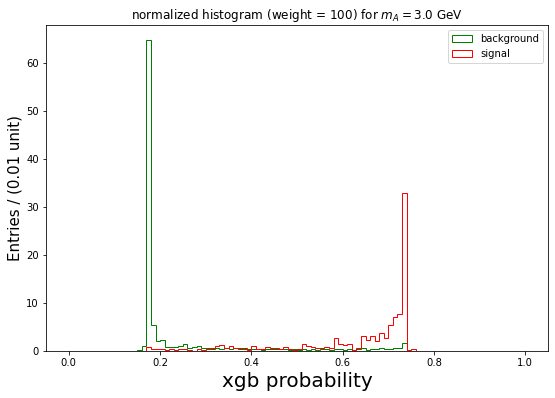

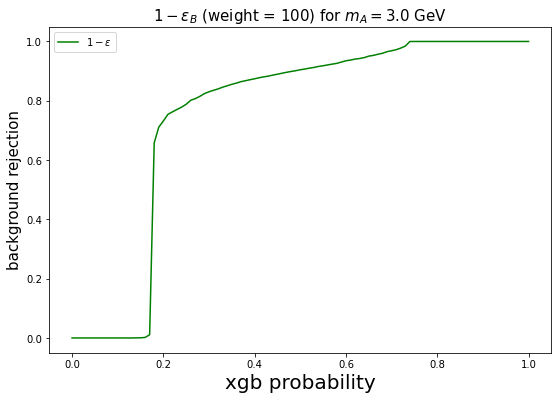

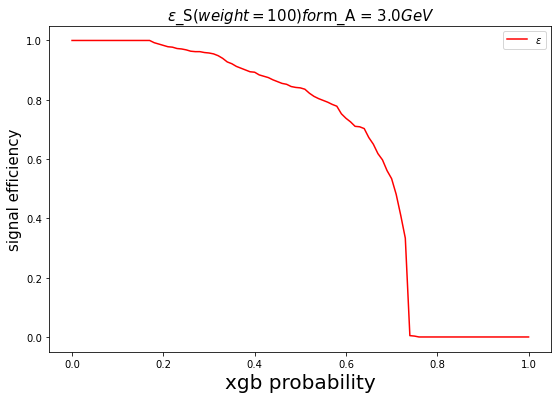

In [6]:
from functions import efficiency


signal_hist, background_hist, sig_eff, background_eff, bin_edges = efficiency(yprob,ytest)
#histogram
plt.figure(figsize=(9,6))
plt.hist(background_hist,bins = bin_edges, density=True, histtype="step", label = "background", color = "g")
plt.hist(signal_hist,bins = bin_edges, density=True, histtype="step", label = "signal", color = "r")
plt.title(f"normalized histogram (weight = {weight}) for $m_A = 3.0$ GeV")
plt.ylabel("Entries / ({:.2f} unit)".format(bin_edges[1]-bin_edges[0]), fontsize = 15)
plt.xlabel("xgb probability", fontsize = 20)
plt.legend()
#plt.savefig(f"/work/aavocone/week3/hist_weight{str(weight)}.jpeg")
plt.show() 

plt.figure(figsize=(9,6))
plt.plot(bin_edges, 1-background_eff, label = "$1-\epsilon$", color ="g")
plt.xlabel("xgb probability", fontsize = 20)
plt.ylabel("background rejection", fontsize = 15)
plt.title(f"$1-\epsilon_B $ (weight = {weight}) for $m_A = 3.0$ GeV", fontsize = 15)
plt.legend()
#plt.savefig(f"/work/aavocone/week3/signal_eff_background_weight{str(weight)}.jpeg")
plt.show() 

plt.figure(figsize=(9,6))
plt.plot(bin_edges, sig_eff, label = "$\epsilon$", color = "r")
plt.xlabel("xgb probability", fontsize = 20)
plt.ylabel("signal efficiency",fontsize=15)
plt.title(f"$ \epsilon$_S$ (weight = {weight}) for $m_A = 3.0$ GeV$", fontsize = 15)
plt.legend()
#plt.savefig(f"/work/aavocone/week3/signal_eff_signal_weight{str(weight)}.jpeg")
plt.show() 






## ROC or precision-recall
https://scipost.org/SciPostPhys.7.6.076/pdf


1. Accuracy is not the ideal metric to use for classifying background AND signal

2. ROC and AUC are allways good for finding the best threshhold

    - true positiv = signal efficiency

    - false positiv = background rejection

3. precision-recall curve is better for imbalanced data


<img src="https://amirhessam88.github.io/notebooks/roc-vs-pr_files/output_17_0.png" alt="Alt-Text" width="500" />






/work/aavocone/anaconda3/envs/Bachelor/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


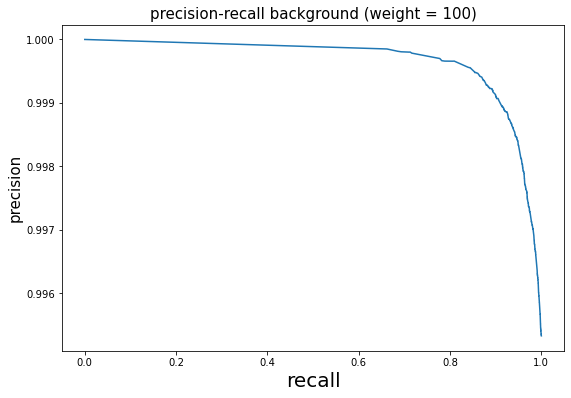

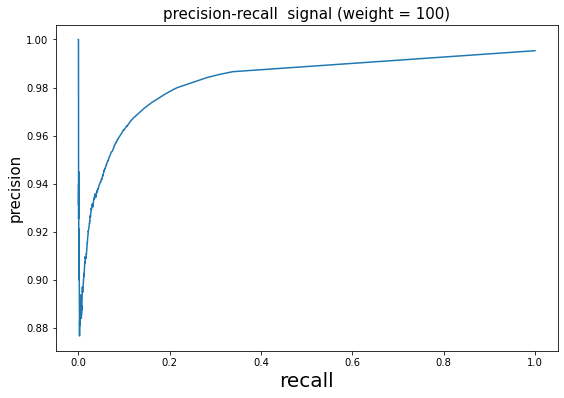

In [7]:
from sklearn.metrics import roc_curve, precision_recall_curve



XGBC = xgb.XGBClassifier(n_estimators = 5, eval_metric = "logloss", use_label_encoder =False)
#cross_score = cross_val_score(model,xtrain,ytrain, cv = StratifiedKFold(n_splits=5, shuffle=True))
XGBC.fit(xtrain,ytrain)
#print(XGBC.classes_)
y_prob = XGBC.predict_proba(xtest)
background_prob = y_prob[:,0]
signal_prob = y_prob[:,1]

    
p1,r1,t1 = precision_recall_curve(ytest, background_prob, pos_label=0)    #pos_label = 0 --> pred_prob  1 --> predict
p2,r2,t2 = precision_recall_curve(ytest, signal_prob, pos_label=0)

plt.figure(figsize=(9,6))
plt.plot(r1, p1)
plt.title(f"precision-recall background (weight = {str(weight)})", fontsize = 15)
plt.xlabel("recall",fontsize = 20)
plt.ylabel("precision", fontsize = 15)
plt.savefig(f"/work/aavocone/week3/presicion_recall_background_weight{str(weight)}.jpeg")
plt.show()

plt.figure(figsize=(9,6))
plt.plot(r2, p2)
plt.title(f"precision-recall  signal (weight = {str(weight)})", fontsize = 15)
plt.xlabel("recall", fontsize = 20)
plt.ylabel("precision", fontsize = 15)
plt.savefig(f"/work/aavocone/week3/presicion_recall_signal_weight{str(weight)}.jpeg")
plt.show()


    

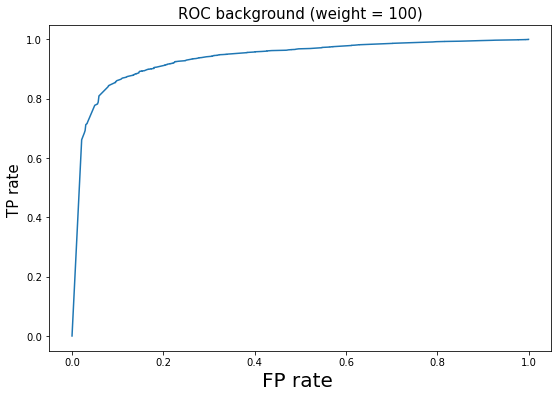

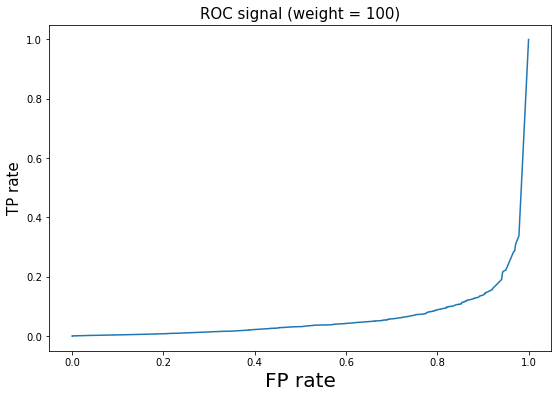

In [8]:
FP1,TP1,t1 = roc_curve(ytest, background_prob, pos_label=0)    #pos_label = 0 --> pred_prob  1 --> predict
FP2,TP2,t2 = roc_curve(ytest, signal_prob, pos_label=0)

plt.figure(figsize=(9,6))
plt.plot(FP1, TP1)
plt.title(f"ROC background (weight = {str(weight)})", fontsize = 15)
plt.xlabel("FP rate ", fontsize = 20)
plt.ylabel("TP rate ", fontsize = 15)
plt.savefig(f"/work/aavocone/week3/ROC_background_weight{str(weight)}.jpeg")
plt.show()


#ROC for signal
plt.figure(figsize=(9,6))
plt.plot(FP2, TP2, label = "signal")
plt.title(f"ROC signal (weight = {weight})", fontsize = 15)
plt.xlabel("FP rate", fontsize = 20)
plt.ylabel("TP rate", fontsize = 15)
plt.savefig(f"/work/aavocone/week3/ROC_signal_weight{str(weight)}.jpeg")
plt.show()

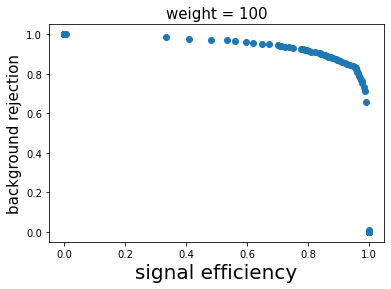

[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.99985835e-01 9.99652952e-01 9.99419226e-01
 9.98293092e-01 9.89114037e-01 3.41926893e-01 2.88970260e-01
 2.68232394e-01 2.45957604e-01 2.37330991e-01 2.29249740e-01
 2.21416379e-01 2.11890276e-01 1.98256263e-01 1.92795575e-01
 1.85082619e-01 1.75853985e-01 1.69692119e-01 1.64734296e-01
 1.59981869e-01 1.54159968e-01 1.49442953e-01 1.44421387e-01
 1.40455128e-01 1.35553966e-01 1.32366794e-01 1.28960061e-01
 1.25836633e-01 1.22302413e-01 1.19327719e-01 1.16884221e-01
 1.13342918e-01 1.10460298e-01 1.07096061e-01 1.03930137e-01
 1.01189169e-01 9.85473578e-02 9.54876727e-02 9.28741917e-02
 8.99915717e-02 8.75834862e-02 8.42404969e-02 8.18536592e-02
 7.90772783e-02 7.63433930e-02 7.38078206e-02 6.95086797e-02
 6.50112259e-02 6.27518751e-02 5.94018032e-02 5.74824174e-02
 5.44298149e-02 4.944366

In [9]:
plt.scatter(sig_eff,1-background_eff)
plt.title(f"weight = {weight}", fontsize = 15)
plt.ylabel("background rejection", fontsize = 15)
plt.xlabel("signal efficiency", fontsize = 20)
plt.savefig(f"/work/aavocone/week3/background_rejection_signal_efficiency{str(weight)}.jpeg")
plt.show()


print(background_eff)